In [8]:
# Load trained model
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

MODEL_NAME = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
# resize token embeddings, base_model is 32000, tokenizer's length is 32008
base_model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

model = PeftModel.from_pretrained(base_model, "crypto-sentiment-model")
model = model.merge_and_unload()

tokenizer = AutoTokenizer.from_pretrained("crypto-sentiment-model", trust_remote_code=True)
tokenizer.pad_token, tokenizer.pad_token_id, tokenizer.padding_side


('<pad>', 32000, 'right')

In [25]:
# load test dataset
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from datasets import load_dataset, DatasetDict, Dataset

connection = sqlite3.connect("crypto-news.db")
test_df = pd.read_sql_query("SELECT * from test", connection)
test_df.shape

(1242, 9)

In [15]:
dataset = {
    "test": Dataset.from_pandas(test_df)
}
dataset

{'test': Dataset({
     features: ['date', 'source', 'subject', 'text', 'title', 'url', 'sentiment', 'polarity', 'subjectivity'],
     num_rows: 1242
 })}

In [9]:
model.pad_token_id = tokenizer.pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [10]:
from transformers import pipeline

pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_new_tokens=16, return_full_text=False)

In [12]:
def format_for_prediction(example):
    return inspect.cleandoc(f"""
    ### Title:
    {example["title"]}
    ### Text:
    {example["text"]}
    ### Prediction:
    """)

In [13]:
from transformers import logging
logging.set_verbosity(logging.CRITICAL)

In [17]:
for i in range(10):
    example = dataset["test"][i]
    print(f"Example {i+1}\n")
    text = inspect.cleandoc(f"""
        Title: {example["title"]}
        Text: {example["text"]}
        Subject: {example["subject"]}
        Sentiment: {example["sentiment"]}
    """)
    print(text)
    print("\nPrediction:")
    outputs = pipe(format_for_prediction(example))
    print(outputs[0]["generated_text"])
    print()

Example 1

Title: Binance Research Report Reveals 110% Surge in Crypto Market Cap YTD
Text: Positive shift in stablecoin supply, NFT trade volume resurgence, and increased fees signal crypto market maturation.
Subject: nft
Sentiment: positive

Prediction:

subject: nft
sentiment: positive
sentiment: positive


Example 2

Title: Bitcoin Price and Ethereum Prediction: BTC Revisits $30,000 \x93 Can Both Cryptocurrencies Bounce Back?
Text: Bitcoin and Ethereum are two major cryptocurrencies that have gained substantial popularity since the beginning of this year. Ethereum (ETH), the second-most popular cryptocurrency, has recently crossed the $2,000 milestone for the first time since May last year.
Subject: altcoin
Sentiment: positive

Prediction:

subject: altcoin
sentiment: positive
sentiment: positive

Example 3

Title: Ethereum's Last Test Before the Merge 'Quite Good' Despite 'Confusion'
Text: Ethereum's final testnet merge before the blockchain transitions to proof-of-stake (PoS) has

In [20]:
import re
from tqdm import tqdm

rows = []
for i in tqdm(range(len(dataset["test"]))):
    try:
        example = dataset["test"][i]
        outputs = pipe(format_for_prediction(example))
        text = outputs[0]["generated_text"]
        parts = re.split(r'[:\n]', text.strip())
        subject, sentiment = parts[1].strip(), parts[3].strip()
    
        rows.append({
            "title": example["title"],
            "text": example["text"],
            "true_subject": example["subject"],
            "true_sentiment": example["sentiment"],
            "pred_subject": subject,
            "pred_sentiment": sentiment
        })
    except:
        print(f"error parts - {parts}")

  8%|███████████▊                                                                                                                                        | 99/1242 [01:28<16:26,  1.16it/s]

error parts - ['ethereum ethereum ethereum ethereum ethereum eth']


 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                | 700/1242 [10:46<08:12,  1.10it/s]

error parts - ['defi blockchain blockchain blockchain defi defi defi defi']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1242/1242 [19:08<00:00,  1.08it/s]


In [21]:
predictions_df = pd.DataFrame(rows)
predictions_df.head()

,title,text,true_subject,true_sentiment,pred_subject,pred_sentiment
0,Binance Research Report Reveals 110% Surge in ...,"Positive shift in stablecoin supply, NFT trade...",nft,positive,nft,positive
1,Bitcoin Price and Ethereum Prediction: BTC Rev...,Bitcoin and Ethereum are two major cryptocurre...,altcoin,positive,altcoin,positive
2,Ethereum's Last Test Before the Merge 'Quite G...,Ethereum's final testnet merge before the bloc...,ethereum,positive,ethereum,positive
3,Coinbase CEO Calls for Regulation of Centraliz...,The demise of FTX has set back crypto by years...,altcoin,positive,altcoin,neutral
4,BNB price rallies on news of DOJ-Binance settl...,The BNB token defied today’s wider market down...,altcoin,positive,altcoin,positive


In [22]:
# Prediction accuracy
(predictions_df["true_subject"] == predictions_df["pred_subject"]).sum()/len(predictions_df)

0.7637096774193548

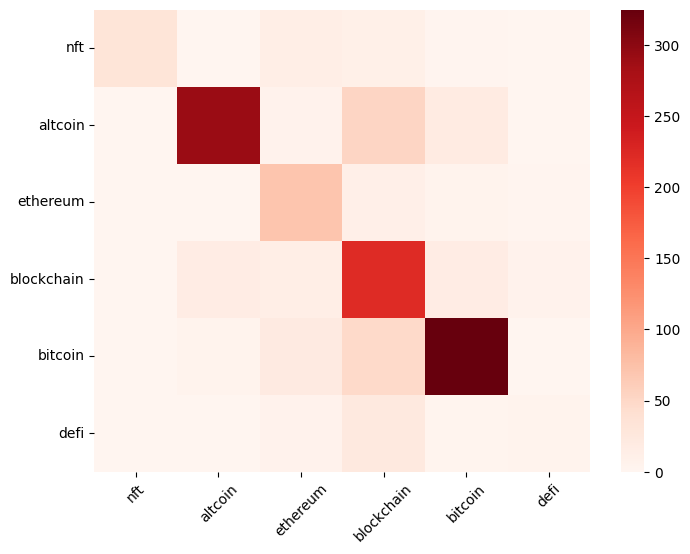

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = predictions_df["true_subject"].unique().tolist()
cf_matrix = confusion_matrix(predictions_df["true_subject"], predictions_df["pred_subject"], labels=labels)
_ , ax = plt.subplots(figsize=(8,6))
sns.heatmap(
    cf_matrix,
    cmap='Reds',
    ax=ax,
)
ax.set_yticklabels(labels, rotation=0)
ax.set_xticklabels(labels, rotation=45);

In [31]:
(predictions_df["true_sentiment"] == predictions_df["pred_sentiment"]).sum()/len(predictions_df)

0.9209677419354839

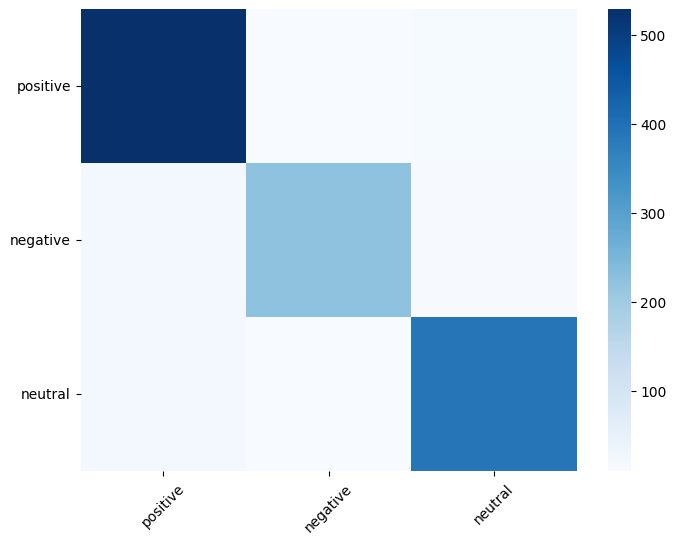

In [36]:
labels = predictions_df["true_sentiment"].unique().tolist()
cf_matrix = confusion_matrix(predictions_df["true_sentiment"], predictions_df["pred_sentiment"], labels=labels)
_ , ax = plt.subplots(figsize=(8,6))
sns.heatmap(
    cf_matrix,
    cmap='Blues',
    ax=ax,
)
ax.set_yticklabels(labels, rotation=0)
ax.set_xticklabels(labels, rotation=45);